# CSGY 6953 Deep Learning Final Project
In this project, we will implement a dual-encoder model for image search. Our model will be trained so that it embeds both images and texts into the same space, and importantly, maps relevant data to be close each other in the embedding space. This will be done by developing two encoders, one for image processing and the other for text encoding, and training them by a similarity-based loss function.<br>
<br>
In this note book, we present our base model, which our further explorations will be compared to. It consists of pretrained InceptionV3 and BERT, fully-connected layers and cosine similarity loss function, hyperparameters such that 256-D embedding space, a fixed learning rate of $0.0005$, and so forth.

## 1. Load the Dataset
Our dataset is called nocaps dataset: https://nocaps.org/ <br>
It consists of 4,500 images with 10 captions for each image. We preprocessed the images to have $299 \times 299$ size. Together with texts, they are stored in dataset.pkl.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import sys

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
with open(f"drive/My Drive/finalproj/data/dataset.pkl", "rb") as f:
    dataset = pickle.load(f)

In [4]:
# Split them into training and test sets.
train_pct = 0.7
threshold = int(len(dataset["images"]) * train_pct)
train_images = dataset["images"][:threshold]
train_texts = dataset["texts"][:threshold * 10]
test_images = dataset["images"][threshold:]
test_texts = dataset["texts"][threshold * 10:]
print(f"Training images: ", len(train_images))
print(f"Training texts: ", len(train_texts))
print(f"Test images: ", len(test_images))
print(f"Test texts: ", len(test_texts))

Training images:  3150
Training texts:  31500
Test images:  1350
Test texts:  13500


## 2. Preprocessing and Setting Up
To train our dual-encoder model, we first preprocess the images and texts.

In [5]:
import torch
from torch.utils.data import DataLoader

In [6]:
# These are the libraries we developed from scratch for this project.
sys.path.append("drive/My Drive/finalproj")
import EncoderHeads, Dataset, utils

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("The device is " + device.type + ".")

The device is cuda.


In [8]:
# Set hyperparameters, choose which models to use.
embed_dim = 256
max_len = 60 # Recommend: 46 for GloVe, 60 for BERT (though the maximum is 146)
image_encoder_model = "InceptionV3"
text_encoder_model = "BERT"
image_head_model = "FC"
text_head_model = "FC"

# To speed up the training, our dataloader stores the output of pretrained nets, not the raw input.
TrainingDataset = Dataset.DualEncoderDataset(train_images, train_texts, device, image_encoder_model, text_encoder_model, max_len=max_len, neg_rate=4)
TestDataset = Dataset.DualEncoderDataset(test_images, test_texts, device, image_encoder_model, text_encoder_model, max_len=max_len, neg_rate=4)
TrainingDataset.print_num_params()


Preprocessing image data...


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

100%|██████████| 99/99 [00:20<00:00,  4.81it/s]


Preprocessing text data...


Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

100%|██████████| 985/985 [00:44<00:00, 22.21it/s]



Preprocessing image data...


100%|██████████| 43/43 [00:05<00:00,  7.22it/s]


Preprocessing text data...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 422/422 [00:19<00:00, 21.57it/s]


=== Image Encoder ===
  Pretrained Parameters: 25,112,264

=== Text Encoder ===
  Pretrained Parameters: 109,482,240


In [9]:
epochs = 20
batch_size = 128
train_loss = []
eval_loss = []
trainloader = DataLoader(TrainingDataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(TestDataset, batch_size=batch_size, shuffle=True)

image_head = EncoderHeads.EncoderHead(image_head_model, TrainingDataset.image_encoder_output_size, embed_dim).to(device)
text_head = EncoderHeads.EncoderHead(text_head_model, TrainingDataset.text_encoder_output_size, embed_dim).to(device)
print(f"=== Image Encoder Head ===")
print(f"  Trainable Parameters: {image_head.num_parameters:,}")
print(f"\n=== Text Encoder Head ===")
print(f"  Trainable Parameters: {text_head.num_parameters:,}")

criterion = torch.nn.CosineEmbeddingLoss(margin=0.1, reduction='sum') # Recipe 1M+ paper sets margin=0.1.
image_optimizer = torch.optim.Adam(image_head.parameters(), lr=0.0005)
text_optimizer = torch.optim.Adam(text_head.parameters(), lr=0.0005)

=== Image Encoder Head ===
  Trainable Parameters: 1,180,416

=== Text Encoder Head ===
  Trainable Parameters: 525,056


Samples from Training Data


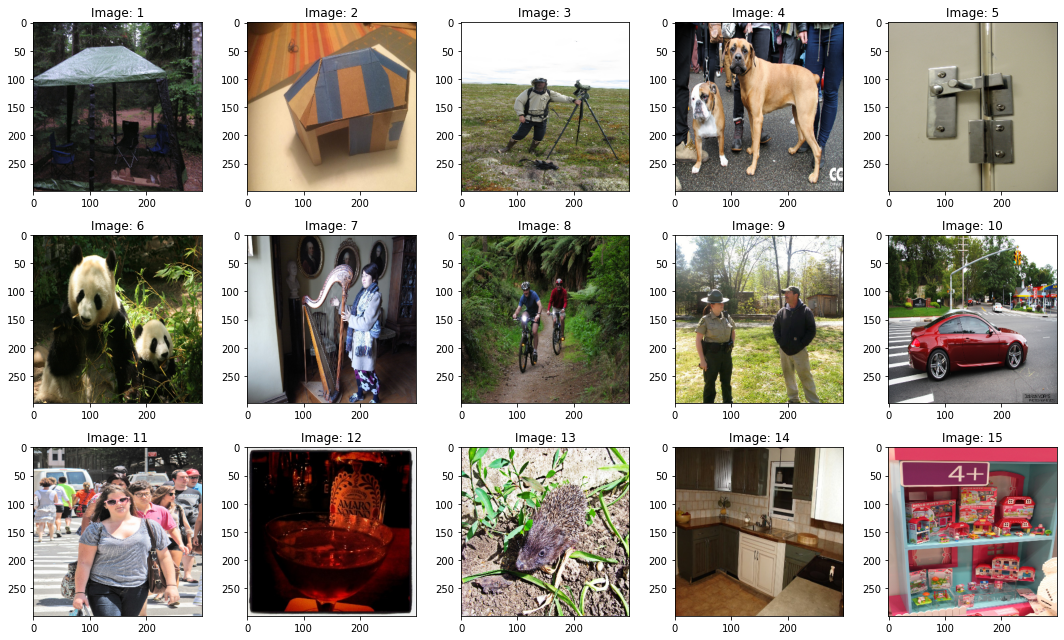

Text: 1 | negative : A man plays a trumpet by a metal wall.
Text: 2 | positive : A toy house made using cardboard cut outs and blue tape sits on a surface.
Text: 3 | negative : The houseplants are shown around the area there.
Text: 4 | negative : The black wheel of a bicycle with the spoke 
Text: 5 | negative : White Lilly's with long green stems in a pot.
Text: 6 | negative : The man is showing another person the large camera.
Text: 7 | negative : A white plate has pancakes, bananas, and sauce on the table.
Text: 8 | negative : Small bathroom with large mirror and a pedestal sink.
Text: 9 | positive : A woman in a hat stands with a man wearing a hat and hoodie.
Text: 10 | positive : A red car is crossing an intersection in the street.
Text: 11 | negative : A salad of sliced greens and other finely chopped food sits in a large white bowl.
Text: 12 | negative : coffee maker and few items are placed on the table and a white color duck is sitting on the cupboard
Text: 13 | negative : A ma

In [10]:
# Let's check if our dataloader works correctly.
print("Samples from Training Data")
utils.show15samples(trainloader, train_images, train_texts)

Samples from Test Data


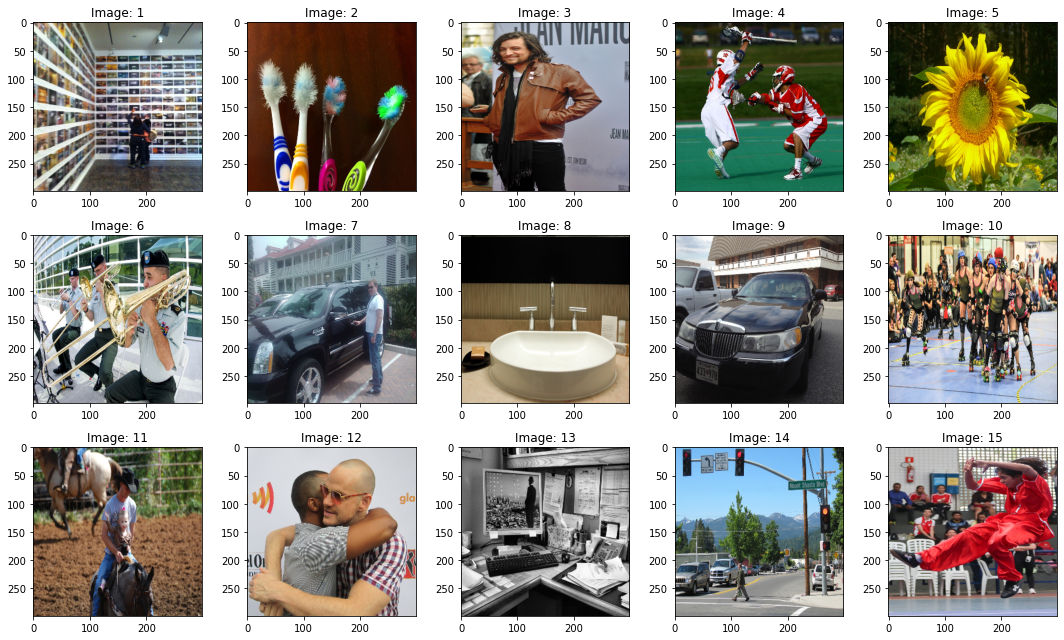

Text: 1 | negative : An old chest of drawers by a trash can. 
Text: 2 | positive : Four toothbrushes in different colors against a wood wall in.
Text: 3 | positive : A man in a brown jacket stands with his hands in his pockets.
Text: 4 | negative : A white plate with utensil's arranged in the letter "E".
Text: 5 | negative : The back of a couch is blue with yellow flowers.
Text: 6 | negative : The sun in illuminating the face of a smiling man wearing sunglasses and headphones. 
Text: 7 | positive : A man standing by a black SUV in a parking lot.
Text: 8 | positive : A white sink that is flat on top of a counter that has soap on the side
Text: 9 | negative : A man wearing a white outfit making sushi.
Text: 10 | negative : A pile of sashimi and a sushi roll.
Text: 11 | negative : A bird is sitting in the grass by some leaves.
Text: 12 | negative : An old car that is being appreciated by police officers standing around it.¬
Text: 13 | negative : A jaguar looking through green cage like fe

In [11]:
print("Samples from Test Data")
utils.show15samples(testloader, test_images, test_texts)

## 3. Training

In [12]:
print("Start Training...")
for epoch in range(epochs):
    trainloss = utils.train(trainloader, image_head, text_head, image_optimizer, text_optimizer, criterion)
    train_loss.append(trainloss)
    evalloss, _ = utils.eval(testloader, image_head, text_head, criterion)
    eval_loss.append(evalloss)
    if (epoch + 1) % 2 == 0:
        print(f"Epoch: {epoch + 1} | Training loss: {trainloss:.4f} | Test loss: {evalloss:.4f}")
_, sim_mat = utils.eval(testloader, image_head, text_head, criterion, only_loss=False)

Start Training...
Epoch: 2 | Training loss: 0.1519 | Test loss: 0.1526
Epoch: 4 | Training loss: 0.0943 | Test loss: 0.1364
Epoch: 6 | Training loss: 0.0815 | Test loss: 0.1311
Epoch: 8 | Training loss: 0.0753 | Test loss: 0.1301
Epoch: 10 | Training loss: 0.0712 | Test loss: 0.1285
Epoch: 12 | Training loss: 0.0682 | Test loss: 0.1279
Epoch: 14 | Training loss: 0.0658 | Test loss: 0.1292
Epoch: 16 | Training loss: 0.0636 | Test loss: 0.1264
Epoch: 18 | Training loss: 0.0618 | Test loss: 0.1273
Epoch: 20 | Training loss: 0.0604 | Test loss: 0.1264


In [13]:
# base_model_loss = {"training": train_loss, "test": eval_loss}
# with open(f"drive/My Drive/finalproj/base_model_loss.pkl", "wb") as f:
#     pickle.dump(base_model_loss, f)

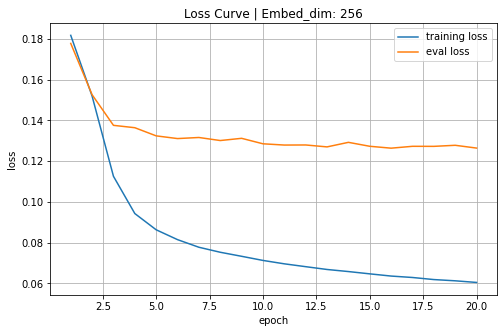

In [14]:
# Plot the loss curves.
plt.figure(figsize=(8,5))
plt.plot(np.arange(1, epochs + 1), train_loss, label="training loss")
plt.plot(np.arange(1, epochs + 1), eval_loss, label="eval loss")
plt.title(f"Loss Curve | Embed_dim: {embed_dim}")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid()
plt.legend()
plt.show()

## 4. Evaluations

First, we check the median rank (MedR) and recall at top K (R@K). In the image retrieval from text, MedR is defined as the median of the rank of the true image over all the test images. So, smaller MedR indicates the model works well. To compute R@K, we take only the top K images for each query text, check if the true image is included, and take the percentage of this recall rate. Thus, higher R@K is better.

Image Retrieval From Text:
   Median Rank: 48.0 / 1350
   Recall at K: 0.1684
Text Retrieval From Image:
   Median Rank: 491.0 / 13500
   Recall at K: 0.0212


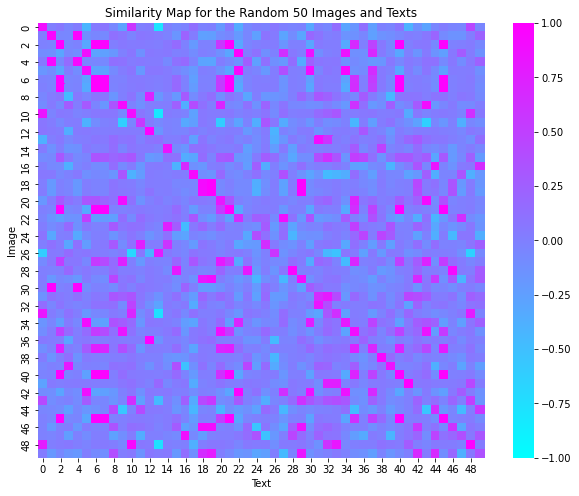

In [15]:
utils.show_performance(testloader, sim_mat)

Ideally in the heatmap, we want $1.0$ for the diagonal entries and $< 0.1$ otherwise ($0.1$ comes from the margin of the CosineEmbeddingLoss function). <br>
<br>
The below is some examples of text retrieval from image, followed by image retrieval from text.

Query Image:


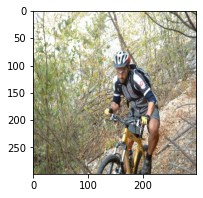

CosSim=0.9680 | A man stares intently while wearing a bicycle helmet. 
CosSim=0.9664 | A man is standing on his bike indoors. 
CosSim=0.9606 | A man wearing a green shirt talks into a walkie-talkie while driving a golf cart with another man beside him.
CosSim=0.9606 | A man dressed in biking gear and wearing a helmet on a city street. 
CosSim=0.9594 | A man wearing jeans on his knee checking a tire.
CosSim=0.9574 | A man is riding a brown horse while wearing a helmet.
CosSim=0.9521 | A man in a blue and black cycling outfit looks at a mirror and takes a picture of himself. 
CosSim=0.9506 | a man that is bald adjusting a bike seat while another guy looks
CosSim=0.9475 | A man wearing sunglasses and a bicycle helmet.
CosSim=0.9440 | A man wears a black bike helmet with the number 721 and a black vest with white trim.


Query Image:


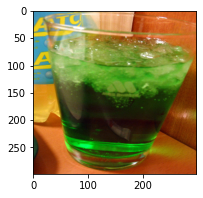

CosSim=0.9952 | A cup of coffee on a sauce next to a spoon. 
CosSim=0.9895 | A white cup containing some soup sits on a saucer. 
CosSim=0.9884 | A pint glass of beer with a slice of orange is sitting on a coaster.
CosSim=0.9879 | A plate of pasta sitting on a table beside a wine glass.
CosSim=0.9871 | A stack of pink and white plates with a cup on top.
CosSim=0.9851 | A slice of lemon is on the side of the glass of an icy drink.
CosSim=0.9840 | White bowl with two handles with soup on it on white saucer sitting on table. 
CosSim=0.9827 | Pink and white cup on top of a pink and white plate.
CosSim=0.9815 | A glass bowl of desserts beside a spoon 
CosSim=0.9800 | A cup plates on two plates beside a glass cup 


Query Image:


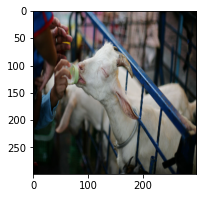

CosSim=0.8545 | A man uses a tool to attach wood together.
CosSim=0.8538 | A man looking at a bag behind a fence.
CosSim=0.8366 | A man on a biillboard drinking liquid from a bottle.
CosSim=0.8336 | A marine corps marching band are holding their trumbones.
CosSim=0.8197 | A guy is holding a hammer and hot iron on an anvil.
CosSim=0.8144 | A man sitting in front of drums in sock feet.
CosSim=0.8129 | A man in a wheat field aiming a gun in a wooded area.
CosSim=0.8115 | A man holding a tool on a forge with a hammer.
CosSim=0.8056 | Person in plaid shirt hammering object on anvil.
CosSim=0.7954 | Military men are in line playing golden tubas.


Query Image:


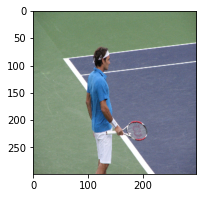

CosSim=0.9930 | A man wearing a baseball uniform is swinging a bat.
CosSim=0.9926 | A person is in a baseball uniform swinging a baseball bat. 
CosSim=0.9925 | A NFL professional quarterback passing the ball to another player.
CosSim=0.9923 | A young man leans as he releases a bowling ball. 
CosSim=0.9918 | A hockey player with helmet and gloves is holding his stick.
CosSim=0.9917 | person dressed as a ninja with one foot raised on a football field with multiple players around them
CosSim=0.9910 | A person about to hit the cue ball while playing billiards.
CosSim=0.9903 | A man wearing sports clothes holding a football.
CosSim=0.9900 | A man wearing a blue shirt  holding a tennis racket.
CosSim=0.9895 | A man in a grey outfit and hat hold a tennis racket while a yellow ball heads toward him. 


Query Image:


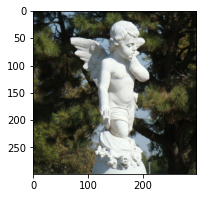

CosSim=0.9133 | Several pictures show a woman wearing a head garment.
CosSim=0.9133 | Animation of a woman with short blonde hair, a crop top, and blue pants. 
CosSim=0.9108 | A drawing shows a woman who is wearing very little clothes with her hand on her head.
CosSim=0.9028 | A statue of legs with some black panties on.
CosSim=0.8918 | A person is laying down in a red outfit holding onto a rose. 
CosSim=0.8900 | A princess with long blond hair drinking wine. 
CosSim=0.8744 | A person is sitting behind a colorful fabric.
CosSim=0.8735 | A beaded sun hat near and image of an older woman wearing a blue hat and suit jacket.
CosSim=0.8654 | A collage of photos of a young woman wearing a scarf around her head and posing with different facial expressions.
CosSim=0.8616 | A woman is wearing a bejeweled necklace and earrings.




In [16]:
utils.TextFromImage(sim_mat, test_images, test_texts)

Query Text: A man sits on a folding chair with wheels attached to it.


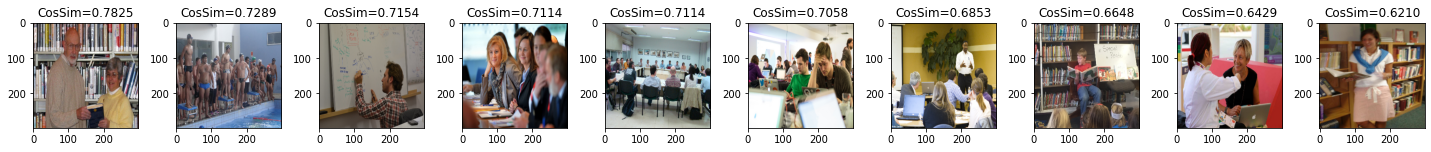



Query Text: A cocktail has a red straw in it with a sprig of mint on the side


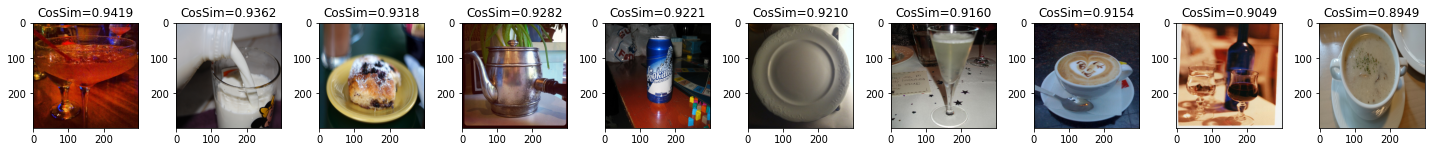



Query Text: A sleek looking white car with red accents and fancy rims.


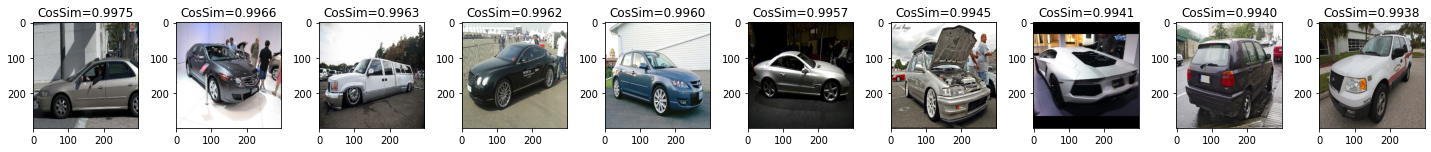



Query Text: Man in bicycle riding gear riding bike down road next to a guardrail. 


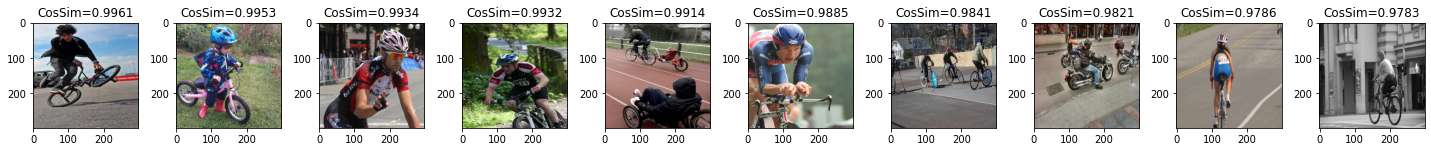



Query Text: A girl with long blonde braids who is smiling.


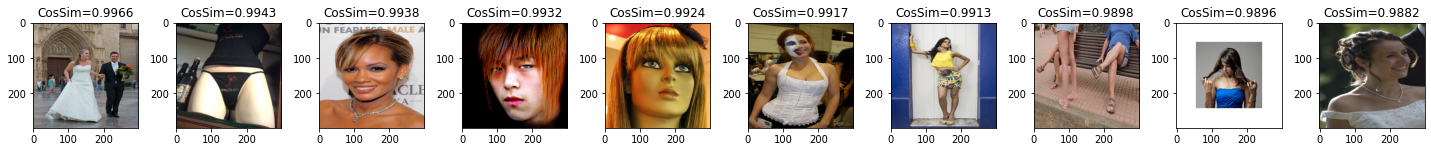

In [17]:
utils.ImageFromText(sim_mat, test_images, test_texts)

Next, we use the t-SNE to visualize our embedding space.

In [18]:
train_image_embeddings, train_text_embeddings = utils.proj(trainloader, image_head, text_head)
test_image_embeddings, test_text_embeddings = utils.proj(testloader, image_head, text_head)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


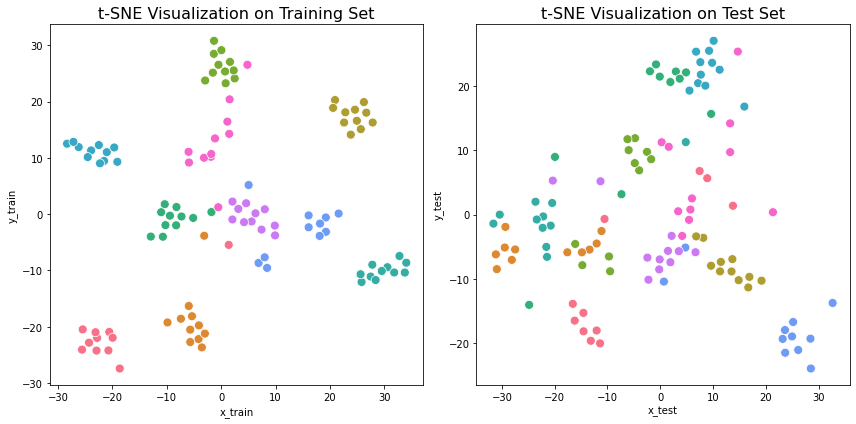

In [19]:
utils.tSNE_visualization(train_image_embeddings, train_text_embeddings, test_image_embeddings, test_text_embeddings)